In [1]:
# Import libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import keras
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.impute import SimpleImputer
from keras.layers import GaussianNoise

In [2]:
# Override how Pandas Datareader reads data
yf.pdr_override()

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [3]:
# Start date, end date and the stock we want to predict
today = datetime.now()
start = datetime(today.year - 2, today.month, today.day)
end = datetime(today.year, today.month, today.day)
print(start)
print(end)
stock = "ZOMATO.NS"

2022-06-07 00:00:00
2024-06-07 00:00:00


In [4]:
# Acquiring the data from YahooFinance
df = yf.download(stock, start, end)

df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-31,178.800003,183.149994,171.250000,179.149994,179.149994,149283415
2024-06-03,184.500000,185.500000,175.000000,175.449997,175.449997,53437123
2024-06-04,176.500000,176.500000,146.300003,172.000000,172.000000,75272859
2024-06-05,175.000000,185.300003,166.750000,183.800003,183.800003,57213537
2024-06-06,185.000000,185.800003,182.500000,183.649994,183.649994,20887553


In [5]:
# Ticker for searching news
stockraw = stock[:-3]

stockraw

'ZOMATO'

In [6]:
# Getting data using html requests
link = f"https://news.google.com/search?q={stockraw}&hl=en-IN&gl=IN&ceid=IN%3Aen"
req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
print(webpage)

b'<!doctype html><html lang="en-IN" dir="ltr"><head><base href="https://news.google.com/"><link ref="preconnect" href="//www.gstatic.com"><meta name="referrer" content="origin"><link rel="canonical" href="https://news.google.com/search"><meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui"><meta name="google-site-verification" content="AcBy5YFny2HQgVUCR18tO5YUTf6MpVlcJqGTd-a9-SI"><meta name="mobile-web-app-capable" content="yes"><meta name="apple-mobile-web-app-capable" content="yes"><meta name="application-name" content="News"><meta name="apple-mobile-web-app-title" content="News"><meta name="apple-mobile-web-app-status-bar-style" content="black"><meta name="theme-color" content="white"><meta name="msapplication-tap-highlight" content="no"><link rel="shortcut icon" href="https://lh3.googleusercontent.com/-DR60l-K8vnyi99NZovm9HlXyZwQ85GMDxiwJWzoasZYCUrPuUM_P_4Rb7ei03j-0nRs0c4F=w16" sizes="16x16"><link rel="shortcut icon" href="https://lh3.googleusercontent.com/-

In [7]:
# Extracting headlines and the dates when they were published to find sentiments
with requests.Session() as c:
    soup = BeautifulSoup(webpage, 'html.parser')

    # Extract titles and datetimes simultaneously
    titles = soup.find_all('a', class_='JtKRv')
    datetimes = soup.find_all('time', class_='hvbAAd')

    # Create lists to store extracted data
    dates_list = []
    titles_list = []

    for title, datetime_tag in zip(titles, datetimes):
        title_text = title.text.strip()  # Remove leading/trailing whitespace from title
        datetime_str = datetime_tag['datetime']
        formatted_datetime = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%S%z')  # Parse datetime string

        # Append data to respective lists
        dates_list.append(formatted_datetime.date())
        titles_list.append(title_text)

    # Create DataFrame
    df2 = pd.DataFrame({'Date': dates_list, 'Headline': titles_list})

    # Print DataFrame
    print(df2.head)

<bound method NDFrame.head of           Date                                           Headline
0   2024-06-06  Food safety department finds multiple health v...
1   2024-06-06  Zomato-owned Blinkit warehouse raided in Hyder...
2   2024-06-07  Zomato’s Blinkit Warehouse in Hyderabad Raided...
3   2024-06-07  'Unhygienic, dusty' Blinkit warehouse in Hyder...
4   2024-06-07  Food safety department finds multiple health v...
..         ...                                                ...
91  2024-05-19  Zomato delivers non-veg thali to a pregnant wo...
92  2024-05-19  Pregnant Zomato Customer Gets Non-Veg Thali In...
93  2024-05-13  Zomato Q4 results today: Expect net profit to ...
94  2024-05-13  Zomato Q4 result: PAT Rs 175cr; fourth consecu...
95  2024-06-03  'Avoid ordering food during these hours'; Zoma...

[96 rows x 2 columns]>


In [8]:
# Loading the tokenizer to generate tokens and model to perform sentiment analysis
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [9]:
# Finding the encodings for each of the headlines found
encoded_headlines = []
for headline in df2['Headline']:
    encoded_headline = tokenizer(headline, padding=True, truncation=True, return_tensors='pt')
    encoded_headlines.append(encoded_headline)
print(encoded_headlines)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'input_ids': tensor([[    0, 29337,  1078,  1494,  5684,  1533,   474,  6165,    71,    24,
         14771,   525,  1075,  3938,    12,  4447, 39897,   405, 12283,    11,
           734,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[    0,  1301,  1075,  3938,    12,  4447, 39897,   405, 12283, 18000,
            11, 17502,  7826,    35,  1216,   689,  1078,  6165,   431,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[    0,  1301,  1075,  3938,    17,    27,    29, 39897,   405, 30778,
            11, 17502,  7826,  4833,  8598,    35, 16210,  1309, 21232,  1635,
         29424, 16223,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[    0,   108,  9685, 11108,   571,  2495,   636,     6, 31430,   108,
         39897,   405, 12283,    11, 175

In [10]:
# Finding the sentiment scores of each headline
# Initialize an empty list to store the tweet sentiments
headline_sentiments = []

# Iterate over the encoded tweets
for encoded_headline in encoded_headlines:
    # Pass the encoded tweet to the model
    output = model(**encoded_headline)

    # Extract the scores
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Calculate the sentiment score between -1 and 1
    sentiment_score = scores[2] - scores[0]  # Assuming 'labels' are ordered as [negative, neutral, positive]

    # Append the sentiment score to the list
    headline_sentiments.append(sentiment_score)

# Print the tweet sentiments
for i in headline_sentiments:
    print(i)

-0.77844924
-0.792099
-0.5046024
-0.62340623
-0.80007213
-0.82509553
-0.6966871
0.6574932
0.13791572
0.1541577
-0.30554822
0.1211287
0.06525854
0.24056636
0.18264426
0.007078074
-0.85779685
-0.4075328
-0.1043338
-0.65578026
-0.4488204
0.57959914
0.27359316
-0.50776666
-0.8143489
-0.36522946
-0.33894733
0.06659452
-0.71689653
0.71004397
-0.6284213
0.038263243
-0.56111985
-0.37950915
0.12802392
-0.05553978
-0.30795076
-0.095593125
-0.5158413
-0.29941013
-0.5480576
-0.3672657
-0.55626285
-0.67963046
0.046949573
0.36297092
-0.19262844
-0.28560764
-0.7392995
-0.052152634
-0.007911809
-0.08634346
0.077591
0.8484369
0.8466177
-0.15811417
-0.69242734
0.18779732
-0.3060223
0.013081405
-0.36758617
-0.1862033
0.13707516
0.7819426
-0.6536953
-0.2807452
0.48952708
0.8690543
-0.6904553
-0.6368169
0.0729883
-0.025127884
-0.27274573
0.05361545
-0.1616154
-0.1449284
-0.049764078
-0.2274538
0.025439128
0.5255165
-0.35844803
0.13525179
-0.6553372
-0.00285583
-0.40178624
0.34918484
-0.34354058
-0.2942222


In [11]:
# Add the tweet sentiments as a new column to the DataFrame
df2['Sentiments'] = headline_sentiments

# Print the DataFrame with the added column
print(df2)

          Date                                           Headline  Sentiments
0   2024-06-06  Food safety department finds multiple health v...   -0.778449
1   2024-06-06  Zomato-owned Blinkit warehouse raided in Hyder...   -0.792099
2   2024-06-07  Zomato’s Blinkit Warehouse in Hyderabad Raided...   -0.504602
3   2024-06-07  'Unhygienic, dusty' Blinkit warehouse in Hyder...   -0.623406
4   2024-06-07  Food safety department finds multiple health v...   -0.800072
..         ...                                                ...         ...
91  2024-05-19  Zomato delivers non-veg thali to a pregnant wo...   -0.175914
92  2024-05-19  Pregnant Zomato Customer Gets Non-Veg Thali In...   -0.417688
93  2024-05-13  Zomato Q4 results today: Expect net profit to ...    0.495105
94  2024-05-13  Zomato Q4 result: PAT Rs 175cr; fourth consecu...    0.124214
95  2024-06-03  'Avoid ordering food during these hours'; Zoma...   -0.310638

[96 rows x 3 columns]


In [12]:
# Convert 'Date' column to datetime if it's not already
df2['Date'] = pd.to_datetime(df2['Date'])

# Group by 'Date' and calculate the average sentiment for each day
average_sentiments = df2.groupby('Date')['Sentiments'].mean().reset_index()

# Print the DataFrame with one row per date and the average sentiment for each day
print(average_sentiments)

         Date  Sentiments
0  2024-05-13    0.331960
1  2024-05-14   -0.348004
2  2024-05-15    0.135252
3  2024-05-17    0.320800
4  2024-05-18    0.137075
5  2024-05-19   -0.296801
6  2024-05-20   -0.011302
7  2024-05-21    0.038501
8  2024-05-22   -0.011471
9  2024-05-23    0.781943
10 2024-05-24    0.187797
11 2024-05-27   -0.052153
12 2024-05-29    0.273593
13 2024-05-30   -0.025128
14 2024-05-31   -0.428166
15 2024-06-01    0.046950
16 2024-06-02   -0.070366
17 2024-06-03   -0.339195
18 2024-06-04   -0.449060
19 2024-06-05    0.109466
20 2024-06-06   -0.217641
21 2024-06-07   -0.330766


In [13]:
# Merge the dataframes on the 'Date' column with a left join to keep all rows from df
merged_df = pd.merge(df, average_sentiments, on='Date', how='left')

# Fill missing sentiment scores with 0
merged_df['Sentiments'].fillna(0, inplace=True)

# If you want to ensure that 'Sentiments' column is of numeric type
merged_df['Sentiments'] = pd.to_numeric(merged_df['Sentiments'])

# If you want to overwrite the 'Sentiments' column with 0 where there's no match
# merged_df['Sentiments'].fillna(0, inplace=True)

merged_df.tail(20)

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiments
473,2024-05-09,195.000000,199.699997,193.100006,195.250000,195.250000,47274769,0.000000
474,2024-05-10,196.350006,205.000000,189.899994,201.300003,201.300003,52717901,0.000000
475,2024-05-13,205.800003,207.199997,186.750000,194.300003,194.300003,114135952,0.331960
476,2024-05-14,191.699997,193.449997,182.100006,187.300003,187.300003,110070781,-0.348004
477,2024-05-15,188.800003,193.399994,183.149994,192.000000,192.000000,44772997,0.135252
478,2024-05-16,192.899994,195.850006,189.000000,195.199997,195.199997,35478593,0.000000
479,2024-05-17,195.149994,196.000000,193.100006,194.850006,194.850006,20841351,0.320800
480,2024-05-21,194.399994,196.500000,188.750000,189.100006,189.100006,33453174,0.038501
481,2024-05-22,190.000000,190.000000,183.350006,185.500000,185.500000,40374419,-0.011471
482,2024-05-23,186.500000,189.399994,184.500000,186.800003,186.800003,20931137,0.781943


In [14]:
print(merged_df.index.dtype)

int64


In [15]:
# Isolating dates to plot graphs more conveniently
train_dates = pd.to_datetime(merged_df['Date'])

print(train_dates)

0     2022-06-07
1     2022-06-08
2     2022-06-09
3     2022-06-10
4     2022-06-13
         ...    
488   2024-05-31
489   2024-06-03
490   2024-06-04
491   2024-06-05
492   2024-06-06
Name: Date, Length: 493, dtype: datetime64[ns]


In [16]:
# Isolate variables for training
cols = list(merged_df)[1:8]
print(cols)
cols2 = list(merged_df)[1:7]
print(cols2)
cols3 = list(merged_df)[1:6]
print(cols3)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sentiments']
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
['Open', 'High', 'Low', 'Close', 'Adj Close']


<Axes: >

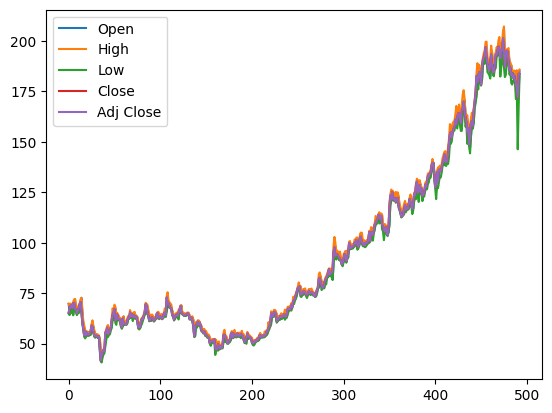

In [17]:
# Displaying Open, High, Low, Close and Adjusted Closing price
df_for_display = merged_df[cols3].astype(float)
df_for_display.plot.line()

<Axes: >

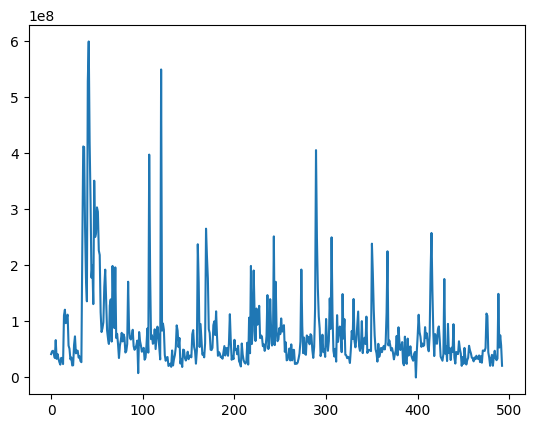

In [18]:
# Displaying traded Volume
df_for_display = merged_df['Volume'].astype(float)
df_for_display.plot.line()

<Axes: >

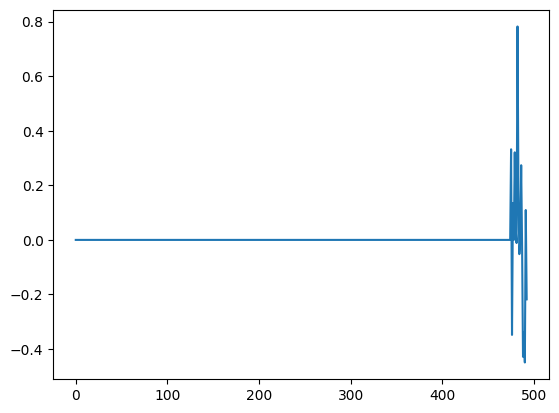

In [19]:
# Displaying Sentiments
df_for_display = merged_df['Sentiments'].astype(float)
df_for_display.plot.line()

In [20]:
# Storing all data to be fed to the model
df_for_training = merged_df[cols].astype(float)

df_for_training

,Open,High,Low,Close,Adj Close,Volume,Sentiments
0,69.699997,69.699997,64.750000,65.400002,65.400002,41755337.0,0.000000
1,66.000000,68.599998,64.099998,67.150002,67.150002,46697875.0,0.000000
2,66.199997,69.699997,65.000000,68.699997,68.699997,47653877.0,0.000000
3,67.300003,69.699997,66.500000,69.000000,69.000000,42040372.0,0.000000
4,67.500000,68.300003,65.400002,67.500000,67.500000,34863276.0,0.000000
...,...,...,...,...,...,...,...
488,178.800003,183.149994,171.250000,179.149994,179.149994,149283415.0,-0.428166
489,184.500000,185.500000,175.000000,175.449997,175.449997,53437123.0,-0.339195
490,176.500000,176.500000,146.300003,172.000000,172.000000,75272859.0,-0.449060
491,175.000000,185.300003,166.750000,183.800003,183.800003,57213537.0,0.109466


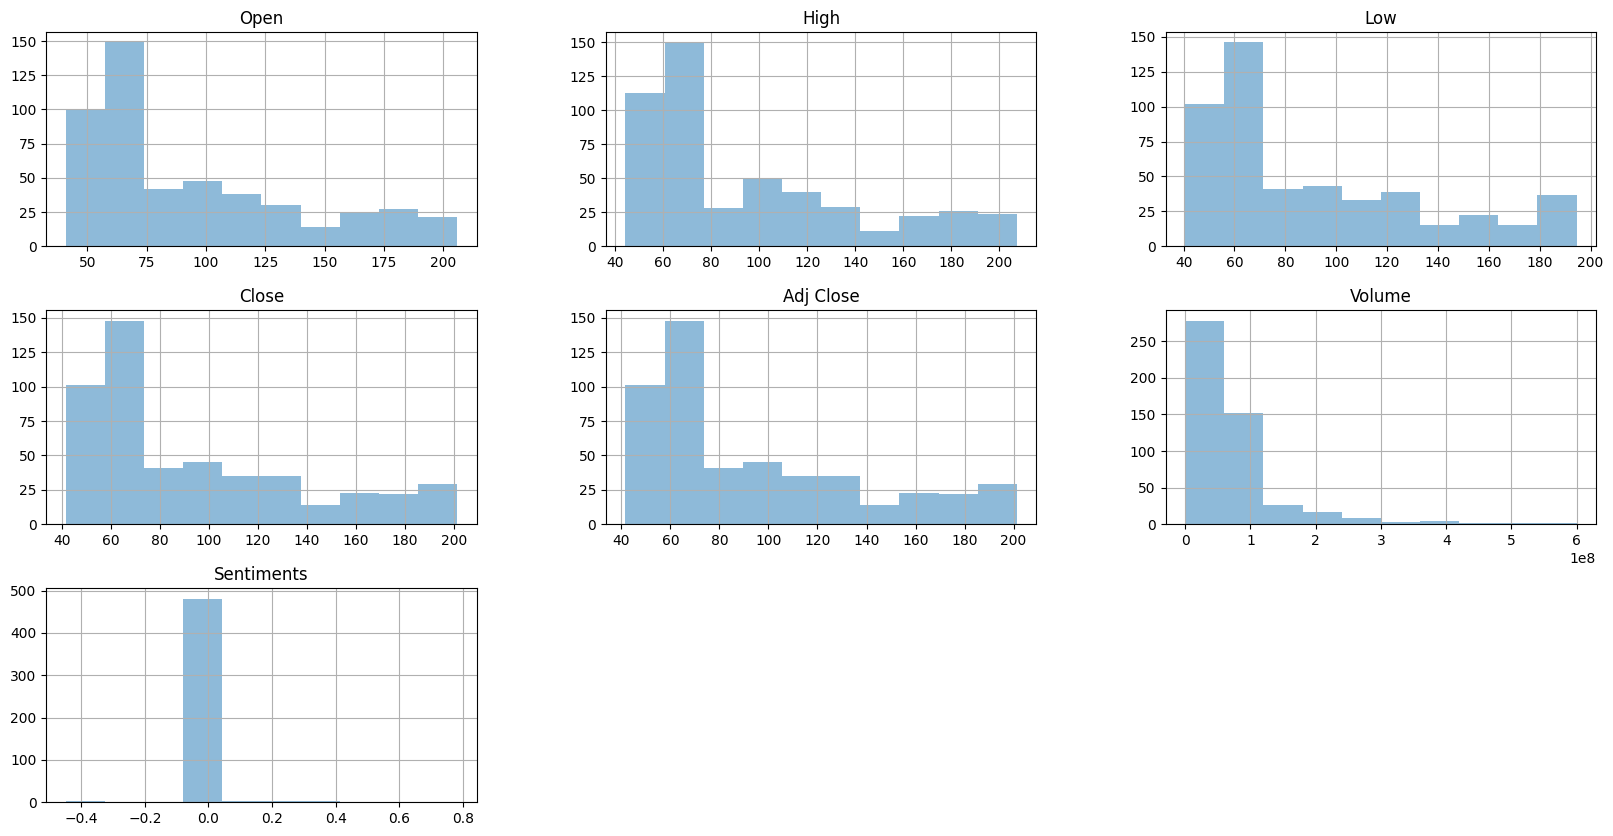

In [21]:
# Plotting the type of distribution of each column in df_for_training
df_for_training.hist(alpha=0.5, figsize=(20,10))
plt.show()

In [22]:
# Selecting the features
dataFrame = merged_df

dataFrame

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiments
0,2022-06-07,69.699997,69.699997,64.750000,65.400002,65.400002,41755337,0.000000
1,2022-06-08,66.000000,68.599998,64.099998,67.150002,67.150002,46697875,0.000000
2,2022-06-09,66.199997,69.699997,65.000000,68.699997,68.699997,47653877,0.000000
3,2022-06-10,67.300003,69.699997,66.500000,69.000000,69.000000,42040372,0.000000
4,2022-06-13,67.500000,68.300003,65.400002,67.500000,67.500000,34863276,0.000000
...,...,...,...,...,...,...,...,...
488,2024-05-31,178.800003,183.149994,171.250000,179.149994,179.149994,149283415,-0.428166
489,2024-06-03,184.500000,185.500000,175.000000,175.449997,175.449997,53437123,-0.339195
490,2024-06-04,176.500000,176.500000,146.300003,172.000000,172.000000,75272859,-0.449060
491,2024-06-05,175.000000,185.300003,166.750000,183.800003,183.800003,57213537,0.109466


In [23]:
# To handle missing values
imputer = SimpleImputer(missing_values=np.nan)

# Removing date and changing index
dataFrame.drop(columns=['Date'], inplace=True)

# Handling Missing values
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
print(dataFrame.shape)

# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
print(list(dataFrame.columns))
print(df_scaled.shape)
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['Open', 'Close']] = target_scaler.fit_transform(dataFrame[['Open', 'Close']].to_numpy())
df_scaled = df_scaled.astype(float)
print(df_scaled.shape)

(493, 7)
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sentiments']
(493, 7)
(493, 7)


In [24]:
# Function to create sequences
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['Open', 'Close']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)

In [25]:
# Dataset splitting
SPLIT = 0.85
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]
print(xVal.shape)
print(yVal.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(473, 20, 7)
(473, 2)
(402, 20, 7)
(402, 2)
(71, 20, 7)
(71, 2)


In [26]:
# Building the model
multivariate_lstm = keras.Sequential()
multivariate_lstm.add(keras.layers.LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
multivariate_lstm.add(keras.layers.Dropout(0.2))
multivariate_lstm.add(keras.layers.Dense(2, activation='linear'))
multivariate_lstm.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
multivariate_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               166400    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 166802 (651.57 KB)
Trainable params: 166802 (651.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Fitting the data to the model
history = multivariate_lstm.fit(X_train, y_train, epochs=100)

Epoch 1/100
13/13 [==============================] - 3s 36ms/step - loss: 0.0205 - MAE: 0.0931
Epoch 2/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0031 - MAE: 0.0378
Epoch 3/100
13/13 [==============================] - 0s 36ms/step - loss: 0.0016 - MAE: 0.0294
Epoch 4/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0013 - MAE: 0.0267
Epoch 5/100
13/13 [==============================] - 0s 36ms/step - loss: 0.0010 - MAE: 0.0230
Epoch 6/100
13/13 [==============================] - 1s 48ms/step - loss: 9.3177e-04 - MAE: 0.0228
Epoch 7/100
13/13 [==============================] - 1s 63ms/step - loss: 9.9026e-04 - MAE: 0.0232
Epoch 8/100
13/13 [==============================] - 1s 58ms/step - loss: 8.6494e-04 - MAE: 0.0218
Epoch 9/100
13/13 [==============================] - 1s 63ms/step - loss: 7.5373e-04 - MAE: 0.0203
Epoch 10/100
13/13 [==============================] - 1s 63ms/step - loss: 8.6867e-04 - MAE: 0.0214
Epoch 11/100
13/13 [=========

In [28]:
list(merged_df.columns)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sentiments']

3/3 [==============================] - 1s 12ms/step


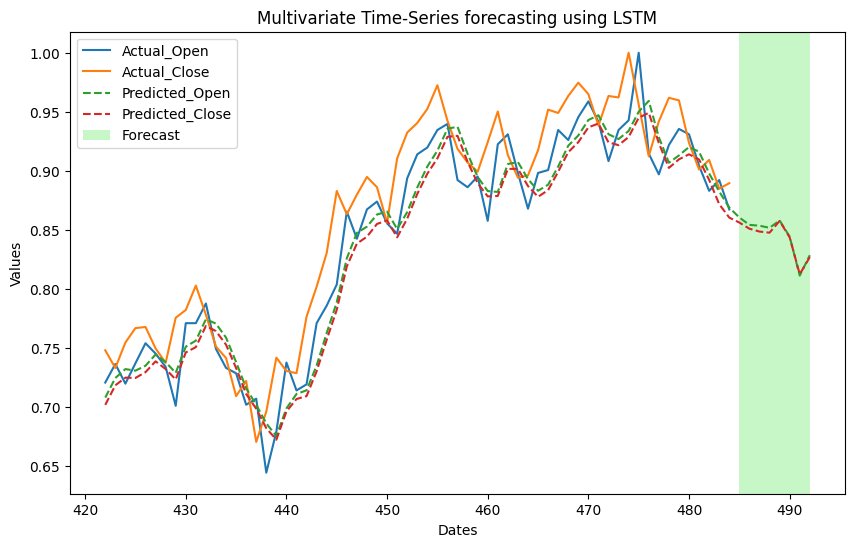

In [29]:
# Reload the data with the date index
dataFrame = merged_df

# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

d = {
	'Predicted_Open': predicted_values[:, 0],
	'Predicted_Close': predicted_values[:, 1],
	'Actual_Open': y_test[:, 0],
	'Actual_Close': y_test[:, 1],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index

fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()


3/3 [==============================] - 0s 16ms/step


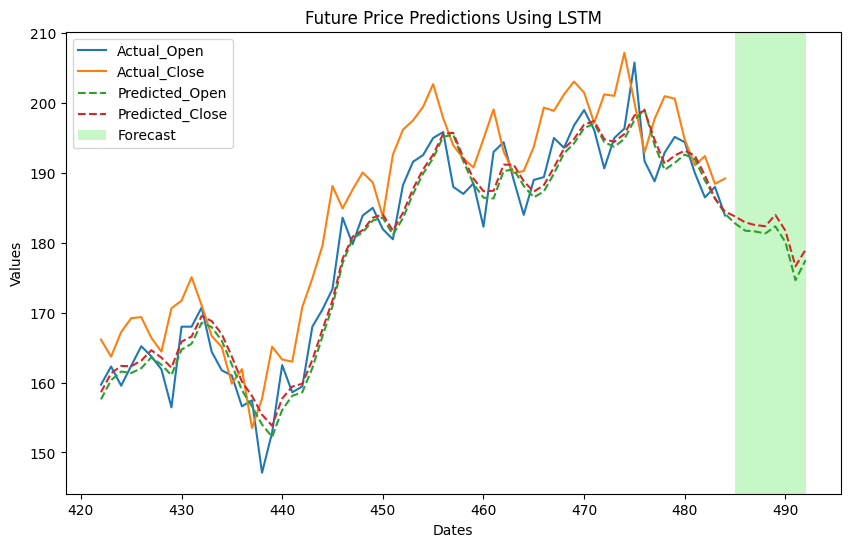

In [30]:
# Reload the data with the date index
dataFrame = merged_df

# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

# Array to compensate for inverse transform shape
additional_zeros = np.zeros((len(y_test),5))
additional_zeros_df = pd.DataFrame(additional_zeros)

# Adding zeros to y_test
y_test_extended = np.concatenate((y_test, additional_zeros), axis=1)

# Adding zeros to predicted_values
predicted_values_extended = np.concatenate((predicted_values, additional_zeros), axis=1)

# Inverse transform the data
y_test_inv = scaler.inverse_transform(y_test_extended)
predicted_values_inv = scaler.inverse_transform(predicted_values_extended)

# Create the DataFrame with inverse-transformed data
d = {
    'Predicted_Open': predicted_values_inv[:, 0],
    'Predicted_Close': predicted_values_inv[:, 1],
    'Actual_Open': y_test_inv[:, 0],
    'Actual_Close': y_test_inv[:, 1],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):]  # Assigning the correct date index

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1  # Adjusted to stay within bounds

# Plot the actual values
plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Future Price Predictions Using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [31]:
predicted_values_inv[-20:, :2]

array([[193.73936047, 194.44723606],
       [194.86275022, 195.57352738],
       [197.5503182 , 198.2272098 ],
       [199.06413802, 198.91314041],
       [193.99188007, 194.74484658],
       [190.42995166, 191.3119913 ],
       [191.4424192 , 192.49470926],
       [192.62364935, 193.18762649],
       [191.95761464, 192.47669931],
       [188.9259538 , 189.65608525],
       [186.40138701, 186.30730228],
       [184.14884608, 184.4576049 ],
       [182.77042962, 183.77230503],
       [181.73828869, 182.92608975],
       [181.62386636, 182.53219006],
       [181.33052518, 182.37756262],
       [182.3559805 , 183.99303363],
       [180.09355863, 181.73098996],
       [174.64813523, 176.64493594],
       [177.50297139, 179.01107052]])